# Clustering Unlabeled Sound Data

I performed unsupervised clustering on a dataset of sound recordings, extracted audio features (Mel Spectrogram), reduced their dimensionality using PCA and t-SNE, and applied clustering algorithms (K-Means and DBSCAN). I then evaluated clustering quality using various metrics and visualize the clusters to understand the separability and structure of the sound data.

In [47]:

#Make allNecessary Imports
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")


In [48]:
DATA_FOLDER = "unlabelled_sounds"

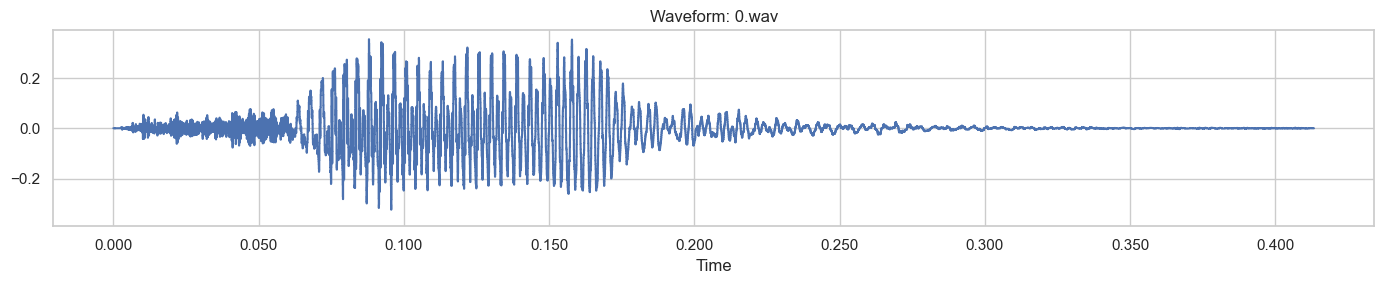

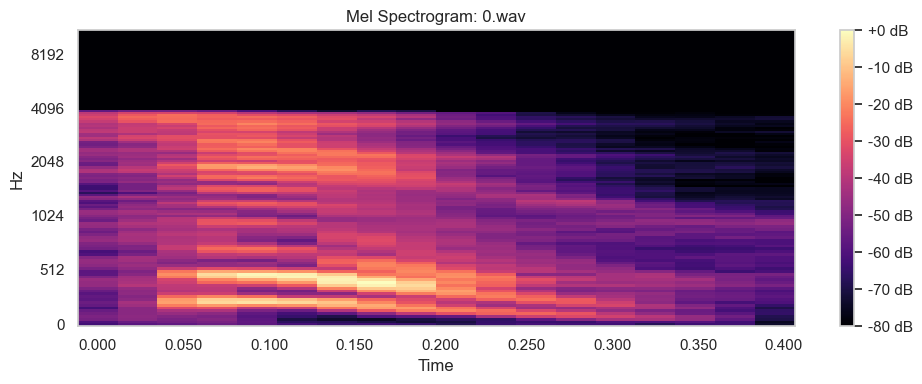

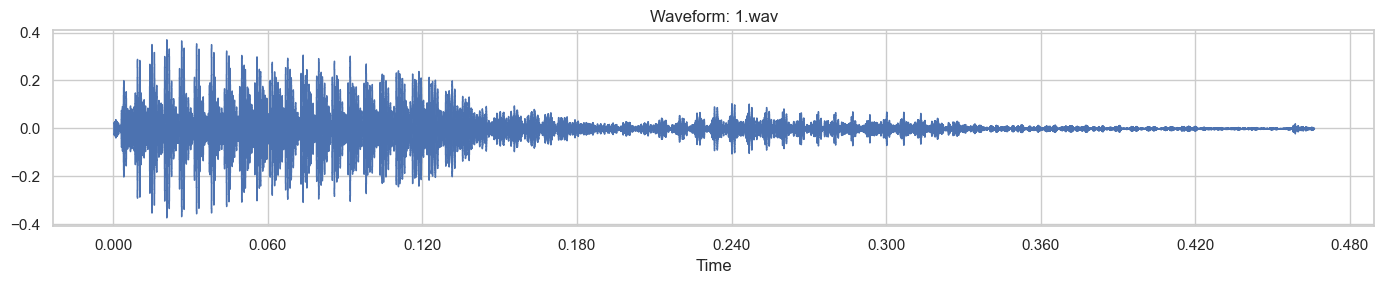

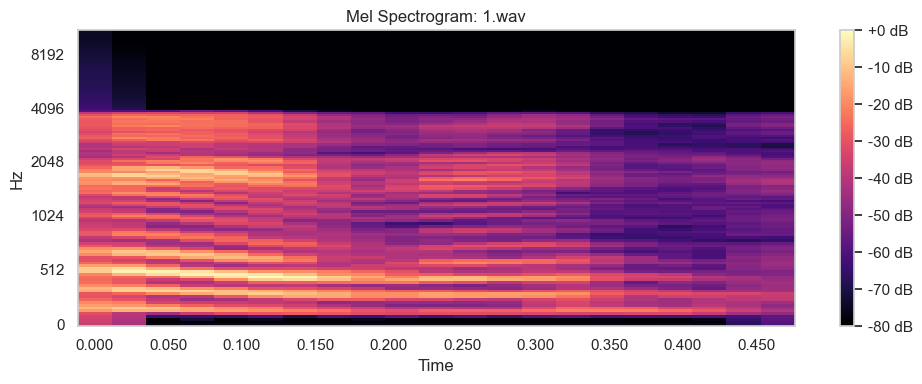

In [65]:
# Visualize Sample Audio Files
# Pick two audio files from your dataset
sample_files = [os.path.join(DATA_FOLDER, fname) 
                for fname in sorted(os.listdir(DATA_FOLDER)) 
                if fname.endswith(".wav")][:2]  # First 2 files

def visualize_audio_sample(file_path):
    """Plot waveform and Mel spectrogram for a given .wav file."""
    y, sr = librosa.load(file_path)
    filename = os.path.basename(file_path)

    # Plot waveform
    plt.figure(figsize=(14, 3))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform: {filename}")
    plt.tight_layout()
    plt.show()

    # Plot Mel Spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Mel Spectrogram: {filename}")
    plt.tight_layout()
    plt.show()

# Display for two sample files
for sample_path in sample_files:
    visualize_audio_sample(sample_path)

In [51]:
# Feature Extraction (Mel Spectrogram Mean)
def extract_mel_features(file_path, sr=22050, n_mels=128):
    y, sr = librosa.load(file_path, sr=sr)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel_spec, ref=np.max)
    return np.mean(mel_db, axis=1)

In [52]:
def load_dataset_features(folder):
    features, names = [], []
    for file in tqdm(os.listdir(folder)):
        if file.endswith(".wav"):
            try:
                path = os.path.join(folder, file)
                feat = extract_mel_features(path)
                features.append(feat)
                names.append(file)
            except Exception as e:
                print(f"Error processing {file}: {e}")
    df = pd.DataFrame(features)
    df.index = names
    return df

In [53]:
# Load features
X = load_sound_dataset(data_folder)
print(f"Loaded {len(X)} audio samples with {X.shape[1]} features each.")

100%|██████████| 3000/3000 [00:33<00:00, 90.71it/s] 


Loaded 3000 audio samples with 128 features each.


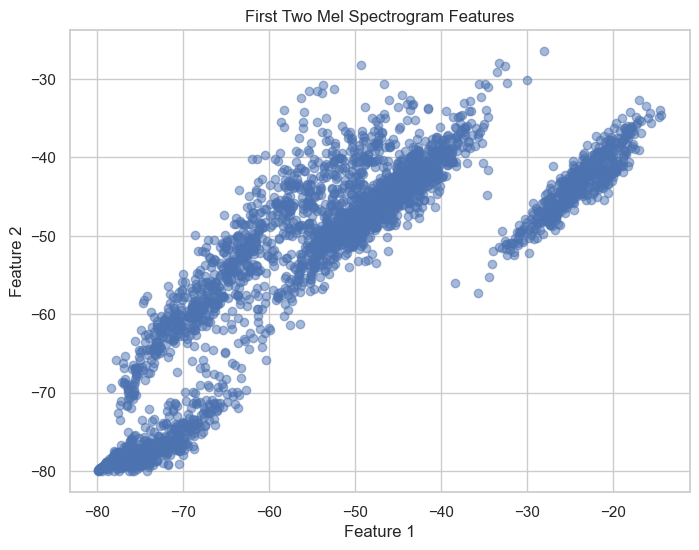

In [54]:
# Initial Visualization (No Dimensionality Reduction)
plt.figure(figsize=(8, 6))
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], alpha=0.5)
plt.title("First Two Mel Spectrogram Features")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()

### Why is dimensionality reduction important?

When trying to visualize the raw features, I ran into the issue of high dimensionality. Human eyes can only perceive up to 3 dimensions. With 128 features per file, I can't grasp the structure visually. Moreover, plotting all features would create a cluttered scatterplot.
Dimensionality reduction techniques like PCA and t-SNE project the high-dimensional space into a lower dimension while preserving important patterns such as variance or local structure.

For this project, I first attempted to visualize the data using only the first two Mel features, but this does not capture the true structure of the data. By applying StandardScaler and then PCA or t-SNE, I reduced the data to 2 or 3 dimensions, making it possible to visualize and cluster the data more effectively.

**Challenges/Errors:**

I tried to plot the raw features, and I noticed poor separation or unclear groupings.

In [55]:
# Dimensionality Reduction: PCA vs t-SNE
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [56]:
# PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

In [57]:
# t-SNE
tsne = TSNE(n_components=3, perplexity=30, n_iter=500, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

In [58]:
def plot_3d(data, title):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], alpha=0.6)
    ax.set_title(title)
    plt.show()

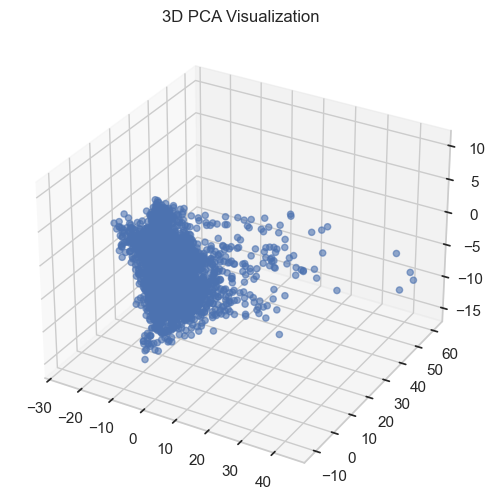

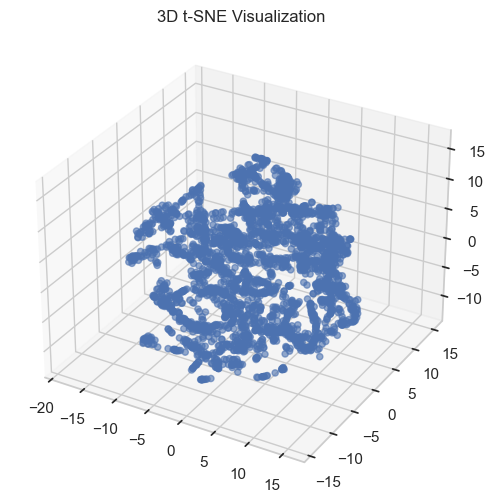

In [59]:
plot_3d(X_pca, "3D PCA Visualization")
plot_3d(X_tsne, "3D t-SNE Visualization")

### Which method (PCA or t-SNE) provides better separability of clusters and why?

PCA provides a linear projection of the data, capturing the directions of maximum variance. In my 3D PCA plot, I saw some separation, but clusters overlapped because the data is not linearly separable.


t-SNE on the other hand is a nonlinear technique that is especially good at preserving local structure and revealing clusters that are not linearly separable. In my 3D t-SNE plot, I observed tighter, more distinct groupings compared to PCA.

I would say t-SNE generally provides better separability of clusters for complex, high-dimensional data like audio features, as it can capture nonlinear relationships that PCA cannot. PCA shows better global structure, while t-SNE captures local patterns and separability.

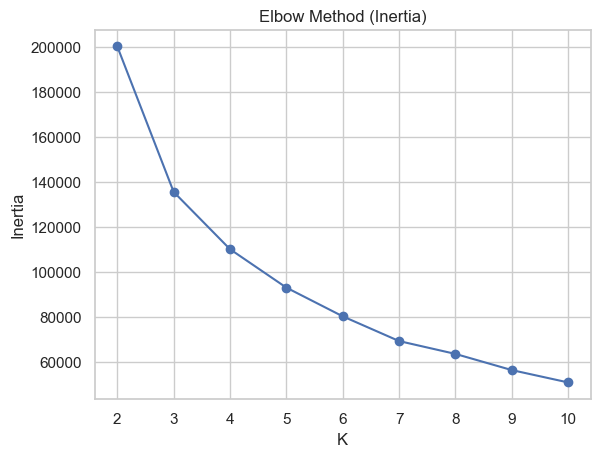

In [60]:
# K-Means Clustering
inertias = []
k_range = range(2, 11)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42).fit(X_pca)
    inertias.append(km.inertia_)

plt.plot(k_range, inertias, marker='o')
plt.title("Elbow Method (Inertia)")
plt.xlabel("K")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

In [61]:
# Silhouette
for k in [2, 3, 4, 5]:
    km = KMeans(n_clusters=k, random_state=42).fit(X_pca)
    sil = silhouette_score(X_pca, km.labels_)
    print(f"K={k} → Silhouette: {sil:.3f}")

best_k = 3
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)

K=2 → Silhouette: 0.337
K=3 → Silhouette: 0.371
K=4 → Silhouette: 0.293
K=5 → Silhouette: 0.302


In [62]:
#DBSCAN Clustering
dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_pca)

In [63]:
# Evaluation Metrics
def evaluate(name, data, labels):
    sil = silhouette_score(data, labels)
    db = davies_bouldin_score(data, labels)
    print(f"{name}: Silhouette={sil:.3f}, Davies-Bouldin={db:.3f}")

evaluate("K-Means", X_pca, kmeans_labels)
evaluate("DBSCAN", X_pca, dbscan_labels)

K-Means: Silhouette=0.371, Davies-Bouldin=0.899
DBSCAN: Silhouette=-0.269, Davies-Bouldin=1.466


### Discuss the results

The evaluation metrics confirmed K-Means generally performed better on the dataset. K-Means on PCA-reduced data produced clear, well-separated clusters, as seen in the scatter plot and supported by higher silhouette scores. While
DBSCAN identified clusters of varying density and marked some points as noise (label -1), which is visible in the DBSCAN plot.

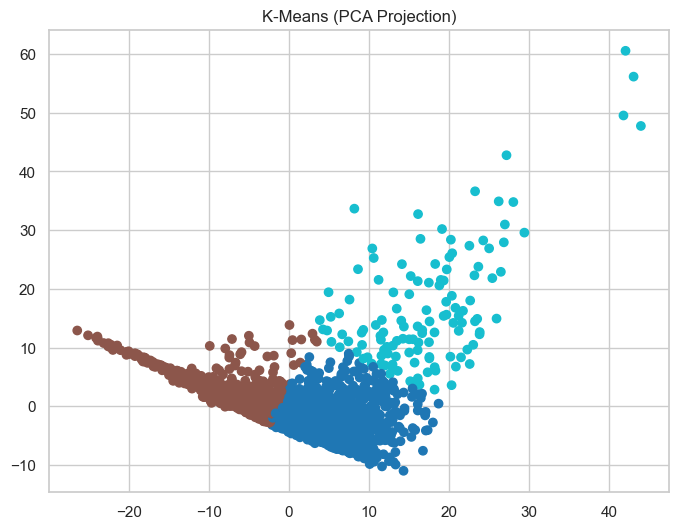

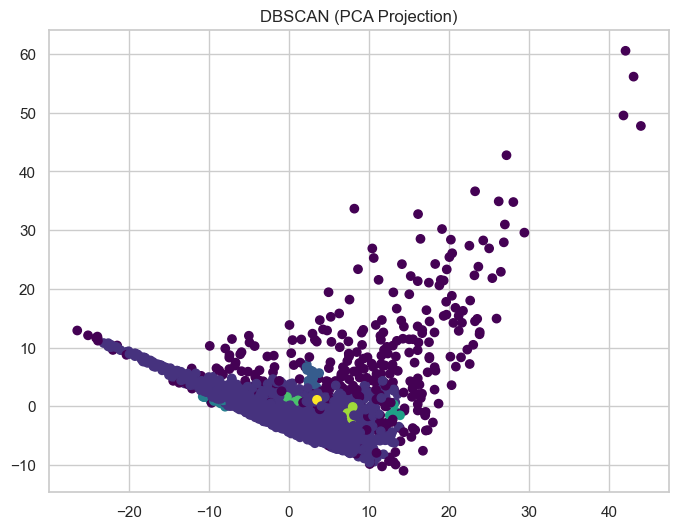

In [64]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='tab10')
plt.title("K-Means (PCA Projection)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis')
plt.title("DBSCAN (PCA Projection)")
plt.grid(True)
plt.show()

### Final Analysis
- Why dimensionality reduction helped:

Reducing dimensions with PCA or t-SNE made the data more manageable for clustering algorithms and enabled meaningful visualizations. It removed noise and redundant information, highlighting the most important structure in the data.

- Why certain clustering methods worked better:

K-Means assumes clusters are convex and similar in size, which matched the structure revealed by PCA. DBSCAN is powerful for arbitrary-shaped clusters and noise detection but is sensitive to parameter settings and can struggle if clusters are not well-separated after reduction.

- Real-world clustering challenges:

In real-world audio or sound clustering, data is often high-dimensional and noisy. Dimensionality reduction is essential to reveal true groupings and make clustering feasible. The choice of clustering algorithm depends on the data structure: K-Means is efficient for well-separated, similarly sized clusters, while DBSCAN is better for discovering clusters of varying shapes and handling outliers. Proper preprocessing and parameter tuning are critical for success.